<a href="https://colab.research.google.com/github/nindywa/mobile_game_A_B_testing_cookie_cats/blob/main/Mobile_Game_A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Description

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. As player progress through the games they will encounter gates that force them to wait some time before they can progress or make in-app purchase.

In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.

## A/B Test

A/B testing is method to compare two or more group to see which one yields better result. The purpose of A/B testing is to measure and compare the performance of two variants based on spesific metrics. By analyzing the data collected from both groups, so we can determined which varian perfoms better and make informed decision on implementing the more effective version.

### Import Libraries and Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/Mobile Game AB Testing/cookie_cats.csv')

### Explore The Dataset

In [ ]:
dataset.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
dataset.shape

(90189, 5)

In [ ]:
dataset.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

In [ ]:
dataset.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [ ]:
dataset.duplicated().sum()

0

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### The Distribution of Game Rounds

In [ ]:
pd.DataFrame(dataset['sum_gamerounds'].describe())

,sum_gamerounds
count,90189.000000
mean,51.872457
std,195.050858
min,0.000000
25%,5.000000
50%,16.000000
75%,51.000000
max,49854.000000


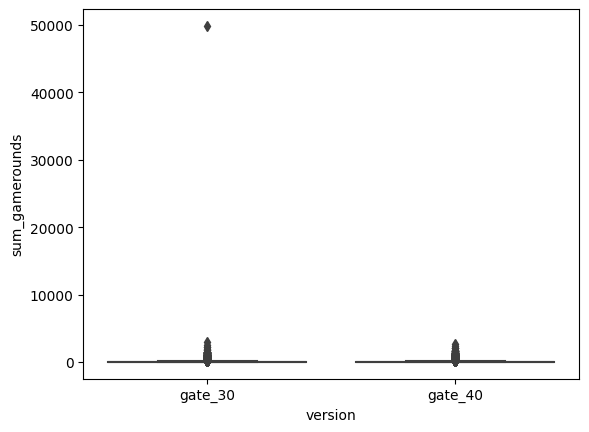

In [ ]:
sns.boxplot(data=dataset, x='version', y='sum_gamerounds')
plt.show()

#### Remove Outlier

In [ ]:
Q1 = dataset['sum_gamerounds'].quantile(0.25)
Q3 = dataset['sum_gamerounds'].quantile(0.75)
IQR = Q3-Q1
upper = Q3+(1.5*IQR)
lower = Q1-(1.5*IQR)
print('Q1:', Q1)
print('Q3:', Q3)
print('upper limit:', upper)
print('lower limit:', lower)

Q1: 5.0
Q3: 51.0
upper limit: 120.0
lower limit: -64.0


In [ ]:
df_min = dataset['sum_gamerounds'] < lower
df_max = dataset['sum_gamerounds'] > upper

In [ ]:
df = dataset[~(df_min|df_max)]

In [ ]:
pd.DataFrame(df['sum_gamerounds'].describe())

,sum_gamerounds
count,80012.000000
mean,23.979178
std,27.481366
min,0.000000
25%,4.000000
50%,13.000000
75%,34.000000
max,120.000000


In [ ]:
df.groupby('version')['sum_gamerounds'].agg(['count','min','mean','std','max'])

,count,min,mean,std,max
version,,,,,
gate_30,39638,0,23.945179,27.152547,120
gate_40,40374,0,24.012558,27.800704,120


#### Distribution of All Version

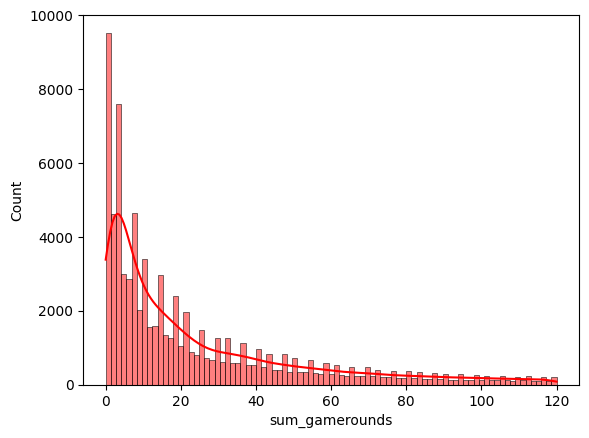

In [ ]:
sns.histplot(data=df, x='sum_gamerounds', kde=True, color='red')
plt.show()

#### Distribution of Gate_30

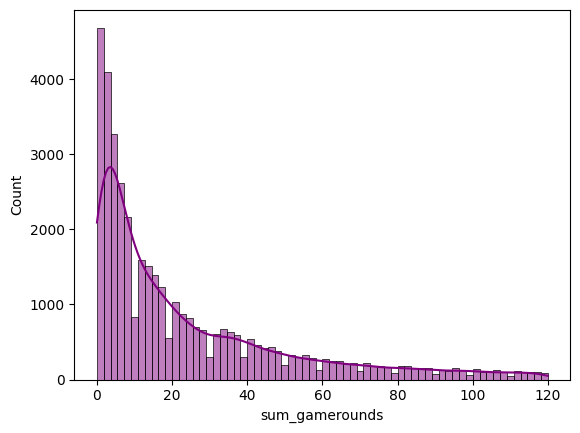

In [ ]:
sns.histplot(data=df[df['version'] == 'gate_30'], x='sum_gamerounds', kde=True, color='purple')
plt.show()

#### Distribution of Gate_40

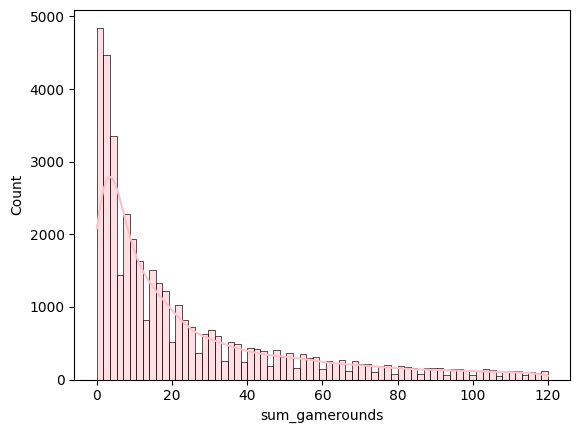

In [ ]:
sns.histplot(data=df[df['version'] == 'gate_40'], x='sum_gamerounds', kde=True, color='pink')
plt.show()

INSIGHT:

The sum_gamerounds distribution on the overall data, gate_30 and gate_40 are positive skewness which means that mostly data distribution is at low value, or mode < median < mean

### Summary of Retention

In [ ]:
df_ret = pd.DataFrame({'Retention 1-Day' : df['retention_1'].value_counts(), 'Retention 7-Day' :df['retention_7'].value_counts()})

In [ ]:
df_ret

,Retention 1-Day,Retention 7-Day
False,49111,70897
True,30901,9115


In [ ]:
ret_1 = pd.DataFrame(df.groupby('version')['retention_1'].value_counts())
ret_1

retention_1
version retention_1             
gate_30 False              24215
        True               15423
gate_40 False              24896
        True               15478

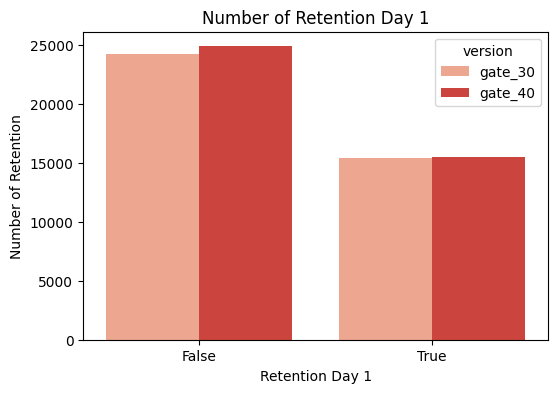

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(df, x='retention_1', hue='version',palette='Reds')
plt.title('Number of Retention Day 1')
plt.xlabel('Retention Day 1')
plt.ylabel('Number of Retention')
plt.show()

In [ ]:
ret_7 = pd.DataFrame(df.groupby('version')['retention_7'].value_counts())
ret_7

retention_7
version retention_7             
gate_30 False              34956
        True                4682
gate_40 False              35941
        True                4433

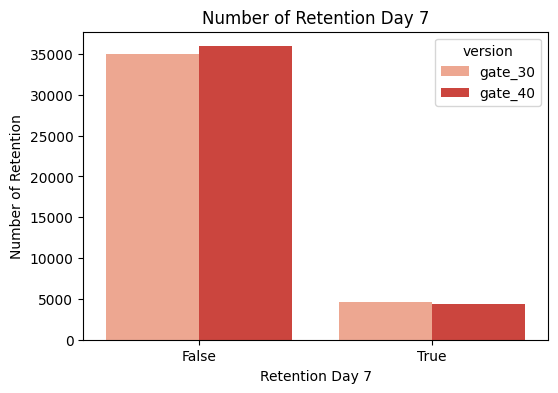

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(df, x='retention_7', hue='version', palette='Reds')
plt.title('Number of Retention Day 7')
plt.xlabel('Retention Day 7')
plt.ylabel('Number of Retention')
plt.show()

**INSIGHT**

From retention analysis shows result:
*  

## A/B Testing

*   Split group to A and B
*   Test normality
*   If normal distribution, check homogenity of variance
*   If normal distribution but not homogenity of variace then apply Welch Test
*   If not normal distribution then apply Mann Whitney U Test

#### Split Data to A and B

In [ ]:
df['version'] = np.where(df['version']=='gate_30', 'A','B')

In [ ]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,A,3,False,False
1,337,A,38,True,False
3,483,B,1,False,False
6,1066,A,0,False,False
7,1444,B,2,False,False


#### Normality Test

In [ ]:
group_A = df[df['version']=='A']['sum_gamerounds']
group_B = df[df['version']=='B']['sum_gamerounds']

In [ ]:
group_A

0         3
1        38
6         0
11        0
13       39
         ..
90179    14
90180     7
90182    21
90183    10
90186    28
Name: sum_gamerounds, Length: 39638, dtype: int64

In [ ]:
group_B

3          1
7          2
8        108
10         3
12        30
        ... 
90181     10
90184     97
90185     30
90187     51
90188     16
Name: sum_gamerounds, Length: 40374, dtype: int64

In [ ]:
normality_A = shapiro(group_A)[1]
normality_B = shapiro(group_B)[1]

In [ ]:
normality_A

0.0

In [ ]:
normality_B

0.0

In [ ]:
p_tresh = 0.05

In [ ]:
if (normality_A >= p_tresh) & (normality_B >= p_tresh):
    print("Distribution is normal")
else:
    print("Distribution not normal")

Distribution not normal


The data distribution is not normal, so we use the Mann Whitney U Test to hypothesis testing

#### Mann Whitney U Test

Null Hypothesis (H0) = There is no statistical significant difference between group A and B

Alternative Hypothesis (Ha) = There is statistical significant difference between group A and B

In [ ]:
pvalue_mannwhitney = mannwhitneyu(group_A, group_B)[1]
pvalue_mannwhitney

0.03885510150342266

In [ ]:
mannwhitneyu(group_A, group_B)

MannwhitneyuResult(statistic=806916458.0, pvalue=0.03885510150342266)

In [ ]:
if (pvalue_mannwhitney > p_tresh):
    print("There is no statistical significant difference between group A and B")
else:
    print("There is statistical significant difference between group A and B")

There is statistical significant difference between group A and B


We reject null hypothesis (pvalue less than 0.5), it means there is statistical significant difference between gate_30 (group_A) and gate_40 (group_B)

### Conclusion

The distribution of data is positive skewness which means that mostly data distribution is at low value. From retention analysis shows that  number of total retention was 5.00% (40,016), where the retention day 1 for gate_30 was 17.10% (15,423) and for gate_40 17.16% (15,478) and at day 7, the number of retention for gate_30 was 5.19% (4,682) and for gate_40 4.91% (4,433).

From A/B test, we get if pvalue less than 0.05, it means we reject null hypothesis and statistical show that there is significant difference between distribution gate_30 and gate_40.

Based on the result, that there is significant impact on player retention. That's why we recommend to move gate before first in-game purchase from level 30 (gate_30) to level 40 (gate_40).